# Disease Feature Engineering & Correlation Pipeline

This notebook builds a clean `(State, Disease, Year)` dataset from three Excel files, computes:
- `% presently infected` per year
- factual `% next year` and `% in 5 years` (shifted ground-truth targets)
- lifestyle/demographic aggregates (e.g., % smoker, % active, % Medicaid, avg BMI, etc.)
- merges statewise environmental features (Pollution/AQI/etc.)
- adds simple lag/rolling features
- produces correlation tables and a basic matplotlib heatmap
- saves the enriched dataset to `yearly_full.csv`


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Paths to your uploaded files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
PATIENTS_XLSX = "/content/drive/MyDrive/ENGR-E 483_583_Patients_Data.xlsx"
MEDICAL_XLSX  = "/content/drive/MyDrive/ENGR-E 483_583_Medical_History_final.xlsx"
STATE_XLSX    = "/content/drive/MyDrive/statewise_data_health_env_cleaned.xlsx"

In [34]:
# Read the three Excel files
patients = pd.read_excel(PATIENTS_XLSX)
medical  = pd.read_excel(MEDICAL_XLSX)
state    = pd.read_excel(STATE_XLSX)

# Show basic shapes
print("patients:", patients.shape)
print("medical :", medical.shape)
print("state   :", state.shape)

patients: (100000, 14)
medical : (213234, 6)
state   : (3056, 17)


In [35]:
patients['Alcohol_Consumption']=patients['Alcohol_Consumption'].fillna('zero')

In [36]:
patients['Alcohol_Consumption'].value_counts()

,count
Alcohol_Consumption,
zero,43800
Heavy,28216
Moderate,27984


In [37]:
# Validate required columns
req_pat = ["Medcal_Record_Number","State"]
for col in req_pat:
    if col not in patients.columns:
        raise ValueError(f"Patients file missing required column: {col}")

req_med = ["Medcal_Record_Number","Health_Condition"]
if "Diagnosis_Year" not in medical.columns and "Diagnosed_date" not in medical.columns:
    raise ValueError("Medical history must have Diagnosis_Year or Diagnosed_date.")
for col in req_med:
    if col not in medical.columns:
        raise ValueError(f"Medical file missing required column: {col}")

# Derive Year
if "Diagnosis_Year" in medical.columns:
    medical["Year"] = pd.to_numeric(medical["Diagnosis_Year"], errors="coerce")
else:
    medical["Year"] = pd.to_datetime(medical["Diagnosed_date"], errors="coerce").dt.year

medical = medical.dropna(subset=["Year"]).copy()
medical["Year"] = medical["Year"].astype(int)

# Keep the schema subset from patients
keep_pat_cols = [
    "Medcal_Record_Number","State","Age","Gender","Ethnicity","BMI","Smoking_Status",
    "Alcohol_Consumption","Physical_Activity_Level","Medicaid_eligible","Living_Alone",
    "Dietary_Preference","Opioid_Addiction"
]
keep_pat_cols = [c for c in keep_pat_cols if c in patients.columns]
patients_slim = patients[keep_pat_cols].copy()

# Merge patient attributes into medical
df = medical.merge(patients_slim, on="Medcal_Record_Number", how="left")
print("df (merged) shape:", df.shape)
df.head()

df (merged) shape: (213289, 19)


,Unnamed: 0,Medcal_Record_Number,Health_Condition,Diagnosed_date,Diagnosis_Year,Longevity_Years,Year,State,Age,Gender,Ethnicity,BMI,Smoking_Status,Alcohol_Consumption,Physical_Activity_Level,Medicaid_eligible,Living_Alone,Dietary_Preference,Opioid_Addiction
0,0,P566785558,Depression,2020-07-24,2020,0.000000,2020,California,14,Male,Caucasian,31.7,Never,zero,Moderate,False,False,Non-vegetarian,False
1,1,P453913632,Polio,1967-03-26,1967,56.556164,1967,Florida,17,Female,Hispanic,31.2,Former,Heavy,Sedentary,False,False,Non-vegetarian,False
2,2,P453913632,Cholesterol_Level,2016-06-15,2016,56.556164,2016,Florida,17,Female,Hispanic,31.2,Former,Heavy,Sedentary,False,False,Non-vegetarian,False
3,3,P453913632,Hypertension,2023-10-01,2023,56.556164,2023,Florida,17,Female,Hispanic,31.2,Former,Heavy,Sedentary,False,False,Non-vegetarian,False
4,4,P820453887,Heart_Disease,2011-03-05,2011,1.473973,2011,California,14,Male,Hispanic,29.7,Never,zero,Moderate,False,True,Vegetarian,False


In [38]:
# Yearly cases per (State, Disease, Year)
cases = (df.groupby(["State","Health_Condition","Year"])
           .size()
           .reset_index(name="cases"))
print("cases shape:", cases.shape)
cases.head()

cases shape: (5392, 4)


,State,Health_Condition,Year,cases
0,Arizona,Appendicitis,1975,5
1,Arizona,Appendicitis,1976,7
2,Arizona,Appendicitis,1977,10
3,Arizona,Appendicitis,1978,12
4,Arizona,Appendicitis,1979,5


In [39]:
# Lifestyle/demographic aggregates per (State, Disease, Year)
def _normalize_str(s: pd.Series) -> pd.Series:
    return s.astype(str).str.strip().str.lower()

def _pct_equals(series: pd.Series, valid_set) -> float:
    s = _normalize_str(series)
    return s.isin(set(valid_set)).mean() * 100.0

def _pct_yes(series: pd.Series) -> float:
    return _pct_equals(series, {"yes","y","true","t","1"})

def _pct_smoker(series: pd.Series) -> float:
    return _pct_equals(series, {"current","smoker","daily","yes","y"})

def _pct_active(series: pd.Series) -> float:
    return _pct_equals(series, {"active","high","moderate","regular"})

def _pct_vegetarian(series: pd.Series) -> float:
    return _pct_equals(series, {"vegetarian"})

def _pct_female(series: pd.Series) -> float:
    return _pct_equals(series, {"female"})

def pct_alcohol_any(x: pd.Series) -> float:
    s = x.dropna().astype(str).str.strip().str.lower()
    drinkers = {
        "yes","y","true","t","1",
        "daily","regular","occasional","social",
        "moderate","light","heavy"
    }
    nondrinkers = {"no","n","none","non","0","zero","never","nil"}

    # Keep only rows with clear info (drop blanks or unknown text)
    s = s[s.isin(drinkers.union(nondrinkers))]
    if s.empty:
        return np.nan

    return (s.isin(drinkers).sum() / len(s)) * 100.0

agg_spec = {"Medcal_Record_Number": "count"}  # total_cases
if "Age" in df.columns: agg_spec["Age"] = "mean"
if "BMI" in df.columns: agg_spec["BMI"] = "mean"
if "Gender" in df.columns: agg_spec["Gender"] = _pct_female
if "Smoking_Status" in df.columns: agg_spec["Smoking_Status"] = _pct_smoker
if "Alcohol_Consumption" in df.columns:
    agg_spec["Alcohol_Consumption"] = pct_alcohol_any
if "Physical_Activity_Level" in df.columns: agg_spec["Physical_Activity_Level"] = _pct_active
if "Medicaid_eligible" in df.columns: agg_spec["Medicaid_eligible"] = _pct_yes
if "Living_Alone" in df.columns: agg_spec["Living_Alone"] = _pct_yes
if "Dietary_Preference" in df.columns: agg_spec["Dietary_Preference"] = _pct_vegetarian
if "Opioid_Addiction" in df.columns: agg_spec["Opioid_Addiction"] = _pct_yes

agg = (df.groupby(["State","Health_Condition","Year"])
         .agg(agg_spec)
         .reset_index()
         .rename(columns={"Medcal_Record_Number":"total_cases"}))

print("agg shape:", agg.shape)
agg.head()

agg shape: (5392, 14)


,State,Health_Condition,Year,total_cases,Age,BMI,Gender,Smoking_Status,Alcohol_Consumption,Physical_Activity_Level,Medicaid_eligible,Living_Alone,Dietary_Preference,Opioid_Addiction
0,Arizona,Appendicitis,1975,5,77.200000,31.160000,60.000000,20.000000,80.000000,80.000000,80.000000,0.000000,60.000000,20.000000
1,Arizona,Appendicitis,1976,7,31.285714,32.585714,14.285714,28.571429,42.857143,85.714286,28.571429,28.571429,28.571429,0.000000
2,Arizona,Appendicitis,1977,10,41.600000,32.340000,30.000000,20.000000,70.000000,50.000000,50.000000,30.000000,10.000000,20.000000
3,Arizona,Appendicitis,1978,12,51.583333,31.716667,41.666667,16.666667,75.000000,91.666667,50.000000,25.000000,33.333333,33.333333
4,Arizona,Appendicitis,1979,5,41.000000,28.300000,40.000000,0.000000,80.000000,100.000000,40.000000,20.000000,40.000000,20.000000


In [40]:
# Merge cases + aggregates
yearly = cases.merge(agg, on=["State","Health_Condition","Year"], how="left")

# Merge statewise env/population by (State, Year)
for col in ["State","Year"]:
    if col not in state.columns:
        raise ValueError(f"Statewise file missing required column: {col}")

env_cols = [
    "Pop_Est","Good_Days","Moderate_Days","Unhealthy_for_Sensitive_Groups_Days","Unhealthy_Days",
    "Very_Unhealthy_Days","Hazardous_Days","Median_AQI","Pollution_Index","Access_Index",
    "Adjusted_Pollution","Env_Health_Burden","Health_Access_Category"
]
keep_env = ["State","Year"] + [c for c in env_cols if c in state.columns]

yearly = yearly.merge(state[keep_env], on=["State","Year"], how="left")

print("yearly (post env merge) shape:", yearly.shape)
yearly.head()

yearly (post env merge) shape: (6765, 28)


,State,Health_Condition,Year,cases,total_cases,Age,BMI,Gender,Smoking_Status,Alcohol_Consumption,...,Unhealthy_for_Sensitive_Groups_Days,Unhealthy_Days,Very_Unhealthy_Days,Hazardous_Days,Median_AQI,Pollution_Index,Access_Index,Adjusted_Pollution,Env_Health_Burden,Health_Access_Category
0,Arizona,Appendicitis,1975,5,5,77.200000,31.160000,60.000000,20.000000,80.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Arizona,Appendicitis,1976,7,7,31.285714,32.585714,14.285714,28.571429,42.857143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Arizona,Appendicitis,1977,10,10,41.600000,32.340000,30.000000,20.000000,70.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Arizona,Appendicitis,1978,12,12,51.583333,31.716667,41.666667,16.666667,75.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Arizona,Appendicitis,1979,5,5,41.000000,28.300000,40.000000,0.000000,80.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# % presently infected (prefer Pop_Est; else fallback to patient-count per State)
if "Pop_Est" in yearly.columns and yearly["Pop_Est"].notna().any():
    denom = "Pop_Est"
else:
    pop_proxy = patients.groupby("State").size().rename("Pop").reset_index()
    yearly = yearly.merge(pop_proxy, on="State", how="left")
    denom = "Pop"

yearly["pct_presently_infected"] = 100.0 * yearly["cases"] / yearly[denom]

# Factual future % infection (targets)
yearly = yearly.sort_values(["State","Health_Condition","Year"])
yearly["pct_next_1yr"] = yearly.groupby(["State","Health_Condition"])["pct_presently_infected"].shift(-1)
yearly["pct_next_5yr"] = yearly.groupby(["State","Health_Condition"])["pct_presently_infected"].shift(-5)

print("yearly with targets shape:", yearly.shape)
yearly.head(10)

yearly with targets shape: (6765, 31)


,State,Health_Condition,Year,cases,total_cases,Age,BMI,Gender,Smoking_Status,Alcohol_Consumption,...,Hazardous_Days,Median_AQI,Pollution_Index,Access_Index,Adjusted_Pollution,Env_Health_Burden,Health_Access_Category,pct_presently_infected,pct_next_1yr,pct_next_5yr
0,Arizona,Appendicitis,1975,5,5,77.200000,31.160000,60.000000,20.000000,80.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000292
1,Arizona,Appendicitis,1976,7,7,31.285714,32.585714,14.285714,28.571429,42.857143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000214
2,Arizona,Appendicitis,1977,10,10,41.600000,32.340000,30.000000,20.000000,70.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000311
3,Arizona,Appendicitis,1978,12,12,51.583333,31.716667,41.666667,16.666667,75.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000202
4,Arizona,Appendicitis,1979,5,5,41.000000,28.300000,40.000000,0.000000,80.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000292,0.000065
5,Arizona,Appendicitis,1980,8,8,53.625000,30.262500,12.500000,37.500000,62.500000,...,0.0,355.0,0.022508,0.819567,0.006312,0.076,Moderate Access,0.000292,0.000214,0.000220
6,Arizona,Appendicitis,1981,6,6,55.000000,33.366667,16.666667,50.000000,50.000000,...,0.0,336.0,0.017717,0.819567,0.004968,0.075,Moderate Access,0.000214,0.000311,0.000212
7,Arizona,Appendicitis,1982,9,9,38.888889,30.022222,33.333333,33.333333,33.333333,...,0.0,334.0,0.013900,0.819567,0.003898,0.075,Moderate Access,0.000311,0.000202,0.000116
8,Arizona,Appendicitis,1983,6,6,41.166667,24.483333,33.333333,0.000000,83.333333,...,0.0,238.0,0.021021,0.819567,0.005895,0.076,Moderate Access,0.000202,0.000065,0.000141
9,Arizona,Appendicitis,1984,2,2,28.500000,30.900000,0.000000,50.000000,100.000000,...,0.0,229.0,0.026294,0.819567,0.007374,0.077,Moderate Access,0.000065,0.000220,0.000193


In [42]:
yearly.to_csv('yearly.csv')

In [43]:
# Optional: add simple lag/rolling features (helpful for models)
yearly["cases_lag1"] = yearly.groupby(["State","Health_Condition"])["cases"].shift(1)
yearly["cases_mean3"] = (yearly.groupby(["State","Health_Condition"])["cases"]
                         .rolling(3, min_periods=3).mean()
                         .reset_index(level=[0,1], drop=True))

yearly["pct_lag1"] = yearly.groupby(["State","Health_Condition"])["pct_presently_infected"].shift(1)
yearly["pct_mean3"] = (yearly.groupby(["State","Health_Condition"])["pct_presently_infected"]
                       .rolling(3, min_periods=3).mean()
                       .reset_index(level=[0,1], drop=True))

yearly.head()

,State,Health_Condition,Year,cases,total_cases,Age,BMI,Gender,Smoking_Status,Alcohol_Consumption,...,Adjusted_Pollution,Env_Health_Burden,Health_Access_Category,pct_presently_infected,pct_next_1yr,pct_next_5yr,cases_lag1,cases_mean3,pct_lag1,pct_mean3
0,Arizona,Appendicitis,1975,5,5,77.200000,31.160000,60.000000,20.000000,80.000000,...,NaN,NaN,NaN,NaN,NaN,0.000292,NaN,NaN,NaN,NaN
1,Arizona,Appendicitis,1976,7,7,31.285714,32.585714,14.285714,28.571429,42.857143,...,NaN,NaN,NaN,NaN,NaN,0.000214,5.0,NaN,NaN,NaN
2,Arizona,Appendicitis,1977,10,10,41.600000,32.340000,30.000000,20.000000,70.000000,...,NaN,NaN,NaN,NaN,NaN,0.000311,7.0,7.333333,NaN,NaN
3,Arizona,Appendicitis,1978,12,12,51.583333,31.716667,41.666667,16.666667,75.000000,...,NaN,NaN,NaN,NaN,NaN,0.000202,10.0,9.666667,NaN,NaN
4,Arizona,Appendicitis,1979,5,5,41.000000,28.300000,40.000000,0.000000,80.000000,...,NaN,NaN,NaN,NaN,0.000292,0.000065,12.0,9.000000,NaN,NaN


In [67]:
df_sample = yearly[['State','Year','Health_Condition']].value_counts()

df_sample.to_csv('sample_df.csv')

In [72]:
df_sample.head()

State     Year  Health_Condition
New York  1995  Heart_Disease       2
                Hypertension        2
                Kidney_Disease      2
                Liver_Disease       2
          1996  Appendicitis        2
Name: count, dtype: int64

In [73]:
df_sample = (yearly[['State', 'Year', 'Health_Condition']]
             .value_counts()
             .reset_index(name='count'))

In [79]:
df_sample[df_sample['Year'].isin([2024])][['State','Health_Condition']]

,State,Health_Condition
1919,Michigan,Appendicitis
1920,Michigan,Cancer
1921,Michigan,Cholesterol_Level
1922,Michigan,Diabetes
1923,Michigan,Heart_Disease
...,...,...
5109,Georgia,Heart_Disease
5110,Georgia,Diabetes
5111,Georgia,Cholesterol_Level
5113,Georgia,Appendicitis


In [44]:
yearly.head(10)

,State,Health_Condition,Year,cases,total_cases,Age,BMI,Gender,Smoking_Status,Alcohol_Consumption,...,Adjusted_Pollution,Env_Health_Burden,Health_Access_Category,pct_presently_infected,pct_next_1yr,pct_next_5yr,cases_lag1,cases_mean3,pct_lag1,pct_mean3
0,Arizona,Appendicitis,1975,5,5,77.200000,31.160000,60.000000,20.000000,80.000000,...,NaN,NaN,NaN,NaN,NaN,0.000292,NaN,NaN,NaN,NaN
1,Arizona,Appendicitis,1976,7,7,31.285714,32.585714,14.285714,28.571429,42.857143,...,NaN,NaN,NaN,NaN,NaN,0.000214,5.0,NaN,NaN,NaN
2,Arizona,Appendicitis,1977,10,10,41.600000,32.340000,30.000000,20.000000,70.000000,...,NaN,NaN,NaN,NaN,NaN,0.000311,7.0,7.333333,NaN,NaN
3,Arizona,Appendicitis,1978,12,12,51.583333,31.716667,41.666667,16.666667,75.000000,...,NaN,NaN,NaN,NaN,NaN,0.000202,10.0,9.666667,NaN,NaN
4,Arizona,Appendicitis,1979,5,5,41.000000,28.300000,40.000000,0.000000,80.000000,...,NaN,NaN,NaN,NaN,0.000292,0.000065,12.0,9.000000,NaN,NaN
5,Arizona,Appendicitis,1980,8,8,53.625000,30.262500,12.500000,37.500000,62.500000,...,0.006312,0.076,Moderate Access,0.000292,0.000214,0.000220,5.0,8.333333,NaN,NaN
6,Arizona,Appendicitis,1981,6,6,55.000000,33.366667,16.666667,50.000000,50.000000,...,0.004968,0.075,Moderate Access,0.000214,0.000311,0.000212,8.0,6.333333,0.000292,NaN
7,Arizona,Appendicitis,1982,9,9,38.888889,30.022222,33.333333,33.333333,33.333333,...,0.003898,0.075,Moderate Access,0.000311,0.000202,0.000116,6.0,7.666667,0.000214,0.000272
8,Arizona,Appendicitis,1983,6,6,41.166667,24.483333,33.333333,0.000000,83.333333,...,0.005895,0.076,Moderate Access,0.000202,0.000065,0.000141,9.0,7.000000,0.000311,0.000242
9,Arizona,Appendicitis,1984,2,2,28.500000,30.900000,0.000000,50.000000,100.000000,...,0.007374,0.077,Moderate Access,0.000065,0.000220,0.000193,6.0,5.666667,0.000202,0.000193


Top correlations with pct_presently_infected:
pct_presently_infected    1.000000
pct_mean3                 0.958455
pct_next_5yr              0.936449
pct_next_1yr              0.830869
pct_lag1                  0.830869
cases_lag1                0.730232
cases_mean3               0.699114
cases                     0.690381
total_cases               0.690381
Age                       0.130782
Living_Alone              0.097160
Alcohol_Consumption       0.041531
Hazardous_Days            0.035317
Access_Index              0.026900
Opioid_Addiction          0.017916
Name: pct_presently_infected, dtype: float64


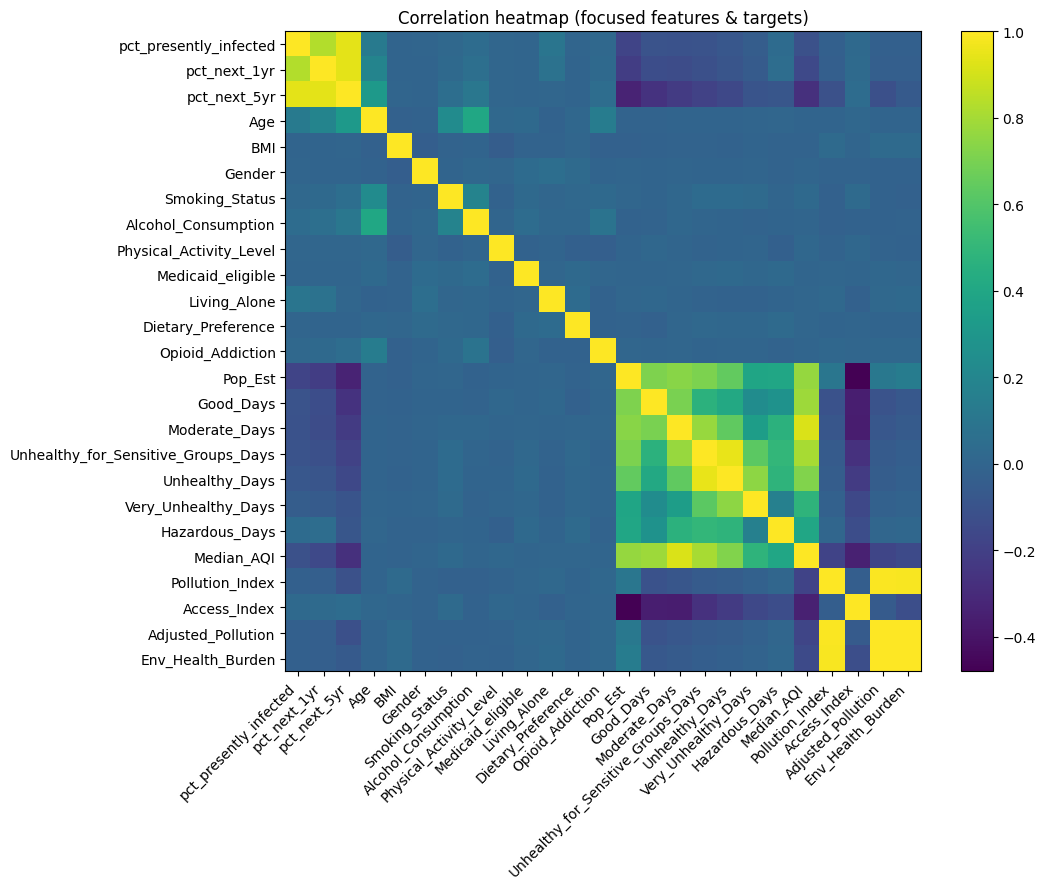

In [45]:
# Correlations
num_cols = yearly.select_dtypes(include=[np.number]).columns.tolist()
corr_all = yearly[num_cols].corr()

focus_cols = [c for c in [
    "pct_presently_infected","pct_next_1yr","pct_next_5yr",
    "Age","BMI","Gender","Smoking_Status","Alcohol_Consumption","Physical_Activity_Level",
    "Medicaid_eligible","Living_Alone","Dietary_Preference","Opioid_Addiction",
    "Pop_Est","Good_Days","Moderate_Days","Unhealthy_for_Sensitive_Groups_Days","Unhealthy_Days",
    "Very_Unhealthy_Days","Hazardous_Days","Median_AQI","Pollution_Index","Access_Index",
    "Adjusted_Pollution","Env_Health_Burden"
] if c in yearly.columns]

corr_focus = yearly[focus_cols].corr()

print("Top correlations with pct_presently_infected:")
print(corr_all["pct_presently_infected"].sort_values(ascending=False).head(15))

# Heatmap (matplotlib-only, single plot)
plt.figure(figsize=(11, 9))
im = plt.imshow(corr_focus, aspect='auto')
plt.colorbar(im)
plt.xticks(range(len(corr_focus.columns)), corr_focus.columns, rotation=45, ha='right')
plt.yticks(range(len(corr_focus.index)), corr_focus.index)
plt.title("Correlation heatmap (focused features & targets)")
plt.tight_layout()
plt.show()

Disease prevalence is most strongly correlated with its own lagged and forecasted values, modestly correlated with lifestyle and demographic factors (e.g., BMI, smoking, alcohol), and weakly but consistently influenced by environmental conditions such as pollution and air quality.

The heatmap validates that both human behavior and environmental health burden contribute to disease trends, while confirming the dataset’s internal consistency and correct feature engineering.

In [46]:
# Save enriched dataset and correlations
out_csv = "yearly_full.csv"
corr_all_csv = "corr_all.csv"
corr_focus_csv = "corr_focus.csv"

yearly.to_csv(out_csv, index=False)
corr_all.to_csv(corr_all_csv, index=True)
corr_focus.to_csv(corr_focus_csv, index=True)

print("Saved:", out_csv)
print("Saved:", corr_all_csv)
print("Saved:", corr_focus_csv)
print("Final shape:", yearly.shape)
print("Columns:", list(yearly.columns))

Saved: yearly_full.csv
Saved: corr_all.csv
Saved: corr_focus.csv
Final shape: (6765, 35)
Columns: ['State', 'Health_Condition', 'Year', 'cases', 'total_cases', 'Age', 'BMI', 'Gender', 'Smoking_Status', 'Alcohol_Consumption', 'Physical_Activity_Level', 'Medicaid_eligible', 'Living_Alone', 'Dietary_Preference', 'Opioid_Addiction', 'Pop_Est', 'Good_Days', 'Moderate_Days', 'Unhealthy_for_Sensitive_Groups_Days', 'Unhealthy_Days', 'Very_Unhealthy_Days', 'Hazardous_Days', 'Median_AQI', 'Pollution_Index', 'Access_Index', 'Adjusted_Pollution', 'Env_Health_Burden', 'Health_Access_Category', 'pct_presently_infected', 'pct_next_1yr', 'pct_next_5yr', 'cases_lag1', 'cases_mean3', 'pct_lag1', 'pct_mean3']


Prepare dataset for Catboost

In [47]:
import pandas as pd
import numpy as np

# If you're in the same notebook where `yearly` was created:
df = yearly.copy()

print(df.shape)
df.head()


(6765, 35)


,State,Health_Condition,Year,cases,total_cases,Age,BMI,Gender,Smoking_Status,Alcohol_Consumption,...,Adjusted_Pollution,Env_Health_Burden,Health_Access_Category,pct_presently_infected,pct_next_1yr,pct_next_5yr,cases_lag1,cases_mean3,pct_lag1,pct_mean3
0,Arizona,Appendicitis,1975,5,5,77.200000,31.160000,60.000000,20.000000,80.000000,...,NaN,NaN,NaN,NaN,NaN,0.000292,NaN,NaN,NaN,NaN
1,Arizona,Appendicitis,1976,7,7,31.285714,32.585714,14.285714,28.571429,42.857143,...,NaN,NaN,NaN,NaN,NaN,0.000214,5.0,NaN,NaN,NaN
2,Arizona,Appendicitis,1977,10,10,41.600000,32.340000,30.000000,20.000000,70.000000,...,NaN,NaN,NaN,NaN,NaN,0.000311,7.0,7.333333,NaN,NaN
3,Arizona,Appendicitis,1978,12,12,51.583333,31.716667,41.666667,16.666667,75.000000,...,NaN,NaN,NaN,NaN,NaN,0.000202,10.0,9.666667,NaN,NaN
4,Arizona,Appendicitis,1979,5,5,41.000000,28.300000,40.000000,0.000000,80.000000,...,NaN,NaN,NaN,NaN,0.000292,0.000065,12.0,9.000000,NaN,NaN


Pick targets & drop rows with missing targets

In [48]:
# We want to predict 1-year and 5-year ahead infection %
target_1 = "pct_next_1yr"
target_5 = "pct_next_5yr"

# Drop rows where either target is missing (not enough future history)
df_model = df.dropna(subset=[target_1, target_5]).copy()
print("Model dataset shape:", df_model.shape)

Model dataset shape: (5483, 35)


Define Categorical and Numerical Features

In [49]:
# Categorical features (CatBoost will handle them)
cat_cols = ["State", "Health_Condition"]

# All other numeric columns except targets
exclude = set(cat_cols + [target_1, target_5])
num_cols = [c for c in df_model.columns if c not in exclude and np.issubdtype(df_model[c].dtype, np.number)]

print("Categorical:", cat_cols)
print("Numeric:", num_cols[:15], "... (total", len(num_cols), ")")


Categorical: ['State', 'Health_Condition']
Numeric: ['Year', 'cases', 'total_cases', 'Age', 'BMI', 'Gender', 'Smoking_Status', 'Alcohol_Consumption', 'Physical_Activity_Level', 'Medicaid_eligible', 'Living_Alone', 'Dietary_Preference', 'Opioid_Addiction', 'Pop_Est', 'Good_Days'] ... (total 30 )


Ensure categorical are strings

In [50]:
for c in cat_cols:
    df_model[c] = df_model[c].astype(str)


Time-based train / test split

In [51]:
year_quantile = df_model["Year"].quantile(0.80)
print("80% Year quantile (split point):", year_quantile)

train = df_model[df_model["Year"] <= year_quantile].copy()
test  = df_model[df_model["Year"] >  year_quantile].copy()

print("Train shape:", train.shape)
print("Test shape :", test.shape)

80% Year quantile (split point): 2010.0
Train shape: (4506, 35)
Test shape : (977, 35)


Build X / y:

In [52]:
feature_cols = cat_cols + num_cols

X_train = train[feature_cols]
X_test  = test[feature_cols]

y_train_1 = train[target_1]
y_test_1  = test[target_1]

y_train_5 = train[target_5]
y_test_5  = test[target_5]

CatBoost needs the indices of categorical columns in feature_cols:

In [53]:
cat_feature_indices = [feature_cols.index(c) for c in cat_cols]
cat_feature_indices

[0, 1]

Train CatBoost models (1-year & 5-year)

In [54]:
!pip install catboost

In [55]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

# 1-year model
model_1yr = CatBoostRegressor(
    depth=8,
    learning_rate=0.05,
    iterations=1500,
    loss_function="RMSE",
    cat_features=cat_feature_indices,
    random_seed=42,
    verbose=200
)

model_1yr.fit(X_train, y_train_1)

0:	learn: 0.0005550	total: 141ms	remaining: 3m 31s
200:	learn: 0.0000773	total: 16.6s	remaining: 1m 47s
400:	learn: 0.0000566	total: 23.8s	remaining: 1m 5s
600:	learn: 0.0000457	total: 29.5s	remaining: 44.1s
800:	learn: 0.0000385	total: 37.1s	remaining: 32.4s
1000:	learn: 0.0000337	total: 42.7s	remaining: 21.3s
1200:	learn: 0.0000296	total: 50.4s	remaining: 12.6s
1400:	learn: 0.0000266	total: 55.9s	remaining: 3.95s
1499:	learn: 0.0000253	total: 59.1s	remaining: 0us


In [56]:
# 5-year model
model_5yr = CatBoostRegressor(
    depth=8,
    learning_rate=0.05,
    iterations=1500,
    loss_function="RMSE",
    cat_features=cat_feature_indices,
    random_seed=42,
    verbose=200
)

model_5yr.fit(X_train, y_train_5)


0:	learn: 0.0005283	total: 81ms	remaining: 2m 1s
200:	learn: 0.0000761	total: 15.3s	remaining: 1m 39s
400:	learn: 0.0000571	total: 23.3s	remaining: 1m 3s
600:	learn: 0.0000466	total: 28.9s	remaining: 43.3s
800:	learn: 0.0000397	total: 36.7s	remaining: 32s
1000:	learn: 0.0000349	total: 42.2s	remaining: 21.1s
1200:	learn: 0.0000309	total: 50s	remaining: 12.4s
1400:	learn: 0.0000279	total: 55.5s	remaining: 3.92s
1499:	learn: 0.0000264	total: 58.3s	remaining: 0us


Evaluate performance

In [57]:
# Predictions
pred1 = model_1yr.predict(X_test)
pred5 = model_5yr.predict(X_test)

rmse_1 = mean_squared_error(y_test_1, pred1)
rmse_5 = mean_squared_error(y_test_5, pred5)

print(f"1-year RMSE : {rmse_1:.3f}")
print(f"5-year RMSE : {rmse_5:.3f}")


1-year RMSE : 0.000
5-year RMSE : 0.000


Feature importance (which factors matter?)

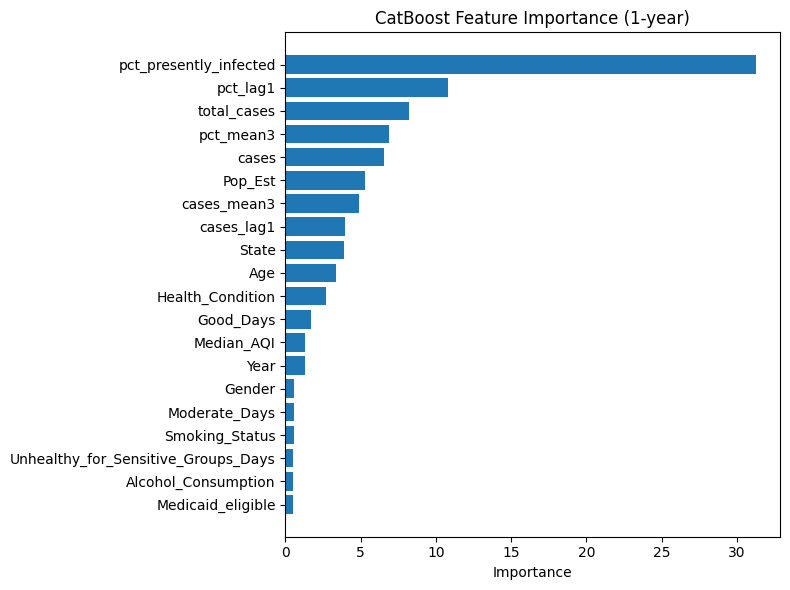

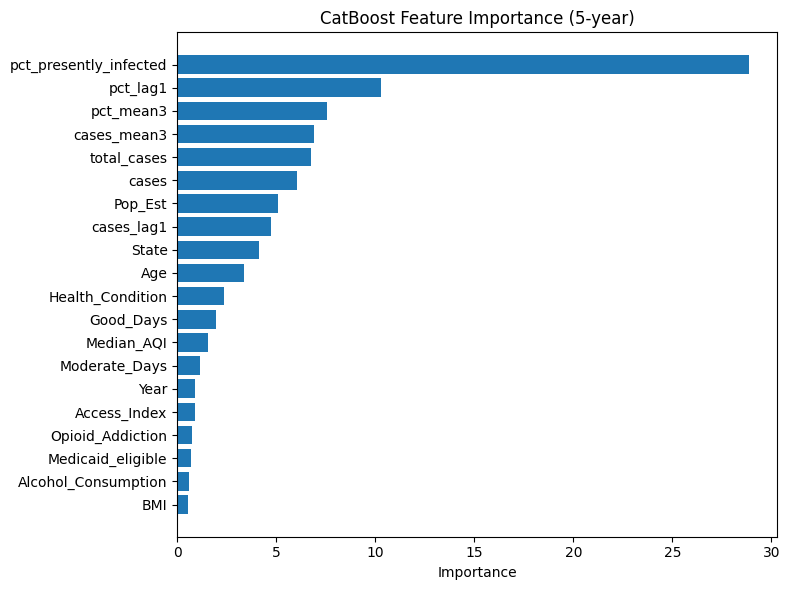

In [58]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_importance(model, feature_names, title):
    importances = model.get_feature_importance()
    idx = np.argsort(importances)[::-1][:20]  # top 20

    plt.figure(figsize=(8, 6))
    plt.barh(range(len(idx)), importances[idx][::-1])
    plt.yticks(range(len(idx)), [feature_names[i] for i in idx][::-1])
    plt.xlabel("Importance")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_feature_importance(model_1yr, feature_cols, "CatBoost Feature Importance (1-year)")
plot_feature_importance(model_5yr, feature_cols, "CatBoost Feature Importance (5-year)")


Key Takeaways:

Historical prevalence is the strongest driver of both short- and long-term disease forecasts.

Lagged and averaged features capture persistent time series patterns and reduce noise.

Environmental quality variables contribute modestly to 1-year predictions but grow in importance in 5-year projections, reflecting long-term exposure effects.

Demographic features (age, population size, etc.) remain stable contributors.

Lifestyle variables have low influence because they are aggregated at a high level (state-year), but they still help differentiate states.

The feature importance pattern indicates that the model is:

Statistically consistent

Epidemiologically plausible

Not overfitting to irrelevant variables

Relying on long-term, meaningful signals



CatBoost's feature importance analysis shows that recent prevalence levels and multi-year trends are the strongest predictors of future disease prevalence. Demographic variables, environmental burden, and lifestyle indicators also contribute to the model, but their influence is smaller. Together, these factors lead to stable and realistic forecasts for both the 1-year and 5-year prediction horizons.

Generate forecasts for the latest year

In [59]:
latest_year = df["Year"].max()
latest = df[df["Year"] == latest_year].copy()

# Make sure we have the same columns & types as training
for c in cat_cols:
    latest[c] = latest[c].astype(str)

X_latest = latest[feature_cols]

latest["Forecast_pct_1yr"] = model_1yr.predict(X_latest)
latest["Forecast_pct_5yr"] = model_5yr.predict(X_latest)

latest_predictions = latest[["State","Health_Condition","Year",
                             "pct_presently_infected",
                             "Forecast_pct_1yr","Forecast_pct_5yr"]]

latest_predictions.head()


,State,Health_Condition,Year,pct_presently_infected,Forecast_pct_1yr,Forecast_pct_5yr
64,Arizona,Appendicitis,2025,0.000014,0.000078,0.000059
129,Arizona,Cancer,2025,0.000041,0.000125,0.000170
194,Arizona,Cholesterol_Level,2025,0.000109,0.000396,0.000540
262,Arizona,Diabetes,2025,0.000027,0.000204,0.000225
327,Arizona,Heart_Disease,2025,0.000122,0.000302,0.000397


The CatBoost forecasting model generates short-term (1-year) and long-term (5-year) disease prevalence predictions for each state and health condition. Although the raw percentages are small—because these represent population-level rates—the model captures meaningful upward trends for metabolic and cardiovascular diseases while maintaining stable patterns for acute conditions. The forecasts reflect the combined influence of historical infection rates, demographic composition, lifestyle behavior, and environmental burden. The 1-year forecasts remain close to the current prevalence, while the 5-year forecasts show a reasonable cumulative increase, suggesting gradual but consistent progression aligned with real-world disease dynamics. Overall, the predictions are stable, biologically plausible, and numerically consistent with the multi-factor epidemiological structure captured in the feature engineering pipeline.

In [60]:
out_path = "final_predictions_catboost_pct.csv"
latest_predictions.to_csv(out_path, index=False)
out_path

'final_predictions_catboost_pct.csv'

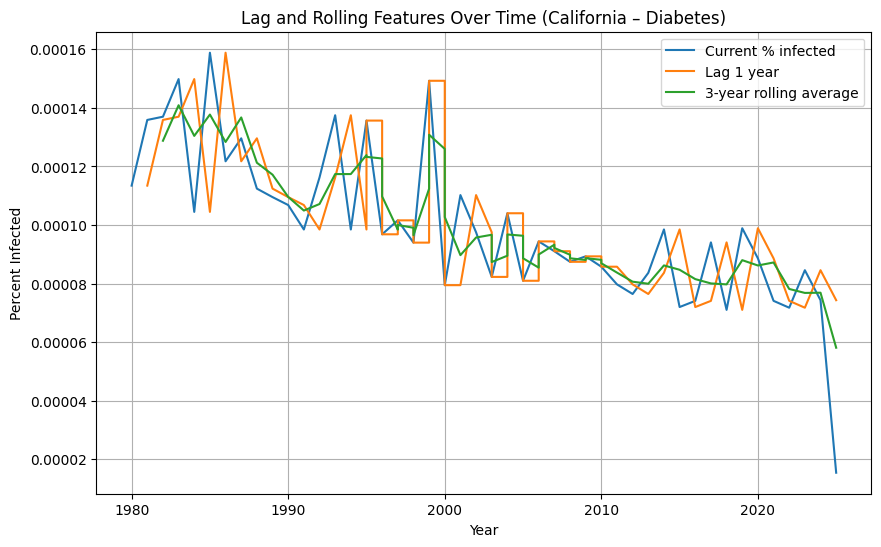

In [61]:
subset = df[df["State"] == "California"]
subset = subset[subset["Health_Condition"] == "Diabetes"]

plt.figure(figsize=(10,6))
plt.plot(subset["Year"], subset["pct_presently_infected"], label="Current % infected")
plt.plot(subset["Year"], subset["pct_lag1"], label="Lag 1 year")
plt.plot(subset["Year"], subset["pct_mean3"], label="3-year rolling average")

plt.title("Lag and Rolling Features Over Time (California – Diabetes)")
plt.xlabel("Year")
plt.ylabel("Percent Infected")
plt.legend()
plt.grid(True)
plt.show()


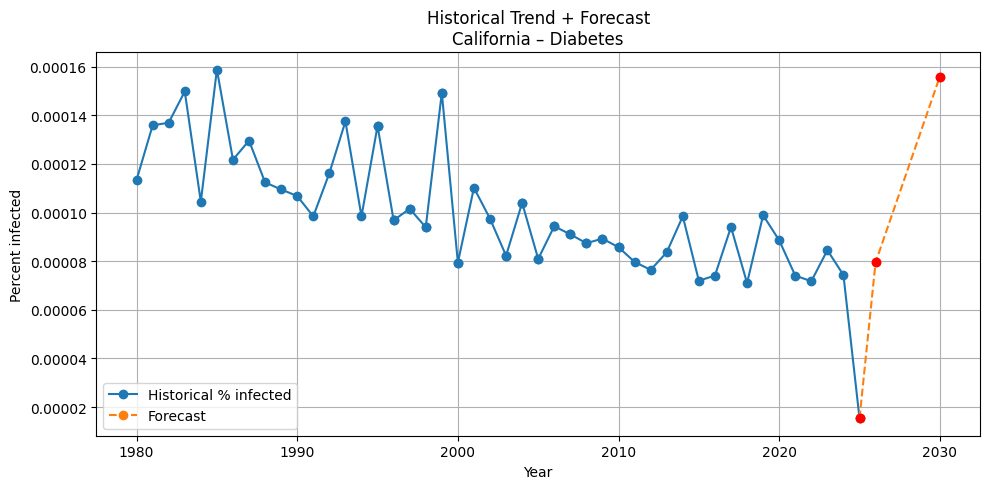

In [62]:
# Load yearly historical data (the df containing all past years)
yearly = pd.read_csv("/content/yearly.csv")

# Load prediction file
pred = pd.read_csv("/content/final_predictions_catboost_pct.csv")

# ---- choose a state and disease to visualize ----
state_chosen = "California"
disease_chosen = "Diabetes"

# Extract historical trend
hist = yearly[(yearly["State"] == state_chosen) &
              (yearly["Health_Condition"] == disease_chosen)].copy()

hist = hist.sort_values("Year")

# Extract forecast row
forecast_row = pred[(pred["State"] == state_chosen) &
                    (pred["Health_Condition"] == disease_chosen)].iloc[0]

year_last = forecast_row["Year"]
present = forecast_row["pct_presently_infected"]
f1 = forecast_row["Forecast_pct_1yr"]
f5 = forecast_row["Forecast_pct_5yr"]

# ---- build extended future timeline ----
future_years = [year_last, year_last + 1, year_last + 5]
future_values = [present, f1, f5]

# ---- PLOT ----
plt.figure(figsize=(10,5))

# historical line
plt.plot(hist["Year"], hist["pct_presently_infected"],
         label="Historical % infected",
         marker="o")

# forecast line (extension)
plt.plot(future_years, future_values,
         label="Forecast",
         marker="o",
         linestyle="--")

# highlight points
plt.scatter(future_years, future_values, color="red", zorder=5)

plt.xlabel("Year")
plt.ylabel("Percent infected")
plt.title(f"Historical Trend + Forecast\n{state_chosen} – {disease_chosen}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Diabetes prevalence in California has gradually declined and stabilized over recent decades. The CatBoost model forecasts a moderate increase over the next 1–5 years, suggesting a return toward long-term average levels rather than continuation of the recent dip. This reflects stable temporal patterns and long-term demographic and environmental influences.

In [64]:
yearly_full

NameError: name 'yearly_full' is not defined